In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')



import random
import math
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(config.seed)

In [5]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

device

device(type='cuda')

In [6]:


transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomGrayscale(p=1)])

transform_validation = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomGrayscale(p=1)])

transform  = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomGrayscale(p=1)])

In [7]:
trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/share/cafir_10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

vaildset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/share/cafir_10',
                                        train=False,
                                        download=False,
                                        transform=transform_validation)

In [8]:
testset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/share/images/Statistical_Deep_Image",
                                           transform = transform)

In [9]:
train_loader = DataLoader(trainset,
                          batch_size = 16,
                          shuffle=True,
                          num_workers=2)

vaild_loader = DataLoader(vaildset,
                          batch_size = 64,
                          shuffle=True,
                          num_workers=2)


test_loader = DataLoader(testset,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)

In [10]:
!pip install timm
import timm


timm.list_models()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 34.4 MB/s 
     |████████████████████████████████| 163 kB 74.0 MB/s 


['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [11]:
net = timm.create_model('mobilevitv2_050', pretrained=False, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

total=0 
correct = 0

In [13]:
for epoch in range(50):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    outputs= net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 750 ==749:
      print("Epoch: {},Batch : {}, Loss:{}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

  with torch.no_grad():
    val_loss = 0.0
    for k, data1 in enumerate(vaild_loader, 0):
      val_inputs, val_label = data1[0].to(device), data1[1].to(device)
      val_output = net(val_inputs)
      v_loss = criterion(val_output, val_label)
      val_loss += v_loss
  print("validation loss : {}".format(val_loss))

  with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs= net(images)
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print("testset Accuracy  : {}".format(100* correct/total))
  total=0
  correct=0


Epoch: 1,Batch : 750, Loss:0.7446064876317978
Epoch: 1,Batch : 1500, Loss:0.731830529332161
Epoch: 1,Batch : 2250, Loss:0.7219536240696907
Epoch: 1,Batch : 3000, Loss:0.7063691694140434
validation loss : 286.4383850097656
testset Accuracy  : 10.858294930875577
Epoch: 2,Batch : 750, Loss:0.6992782508134842
Epoch: 2,Batch : 1500, Loss:0.6876995900869369
Epoch: 2,Batch : 2250, Loss:0.6884982751607895
Epoch: 2,Batch : 3000, Loss:0.6744790700674057
validation loss : 275.5428161621094
testset Accuracy  : 11.65
Epoch: 3,Batch : 750, Loss:0.6609094428420067
Epoch: 3,Batch : 1500, Loss:0.6609913058280945
Epoch: 3,Batch : 2250, Loss:0.6597659912705421
Epoch: 3,Batch : 3000, Loss:0.6553507989048958
validation loss : 263.8437805175781
testset Accuracy  : 11.75
Epoch: 4,Batch : 750, Loss:0.6461158751249313
Epoch: 4,Batch : 1500, Loss:0.6402482949495315
Epoch: 4,Batch : 2250, Loss:0.631577436208725
Epoch: 4,Batch : 3000, Loss:0.6228244494795799
validation loss : 254.15223693847656
testset Accuracy  

pretrained 넣기


In [ ]:
PATH = '/content/drive/MyDrive/share/trained_model/cifar_effnetv2_s.pth'



In [ ]:
torch.save(net.state_dict(), PATH)

In [14]:
classes = ('plane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck')

In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    c= (predicted == labels).squeeze()
    for i in range(4):
      label= labels[i]
      class_correct[label]+= c[i].item()
      class_total[label]+= 1

for i in range(10):
  print("Accuracy of {} : {} %".format(classes[i],100* class_correct[i]/class_total[i]))

Accuracy of plane : 37.5 %
Accuracy of automobile : 16.666666666666668 %
Accuracy of bird : 25.0 %
Accuracy of cat : 0.0 %
Accuracy of deer : 25.0 %
Accuracy of dog : 16.666666666666668 %
Accuracy of frog : 16.666666666666668 %
Accuracy of horse : 25.0 %
Accuracy of ship : 43.75 %
Accuracy of truck : 50.0 %


In [16]:
correct = 0
total = 0
with torch.no_grad():
  for data in train_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print("trainset Accuracy  : {}".format(100* correct/total))

trainset Accuracy  : 72.802


In [17]:
correct = 0
total = 0
with torch.no_grad():
  for data in vaild_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print("vaildset Accuracy  : {}".format(100* correct/total))

vaildset Accuracy  : 67.4


In [18]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print("testset Accuracy  : {}".format(100* correct/total))

testset Accuracy  : 22.1


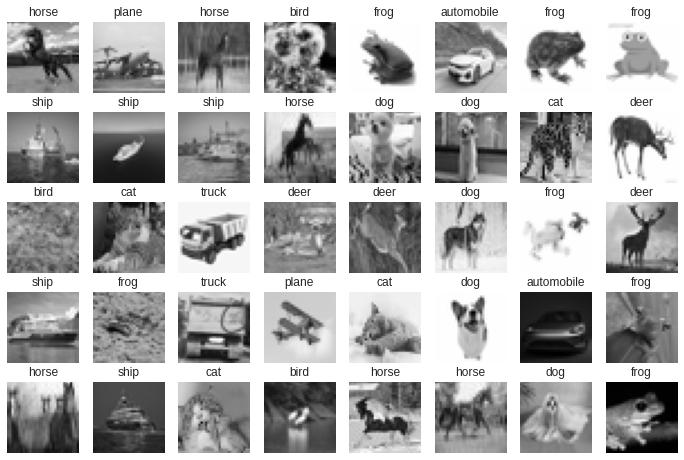

In [21]:
import matplotlib.pyplot as plt
classes = ('plane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck')
labels_map = {
    0: "plane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testset), size=(1,)).item()
    img, label = testset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

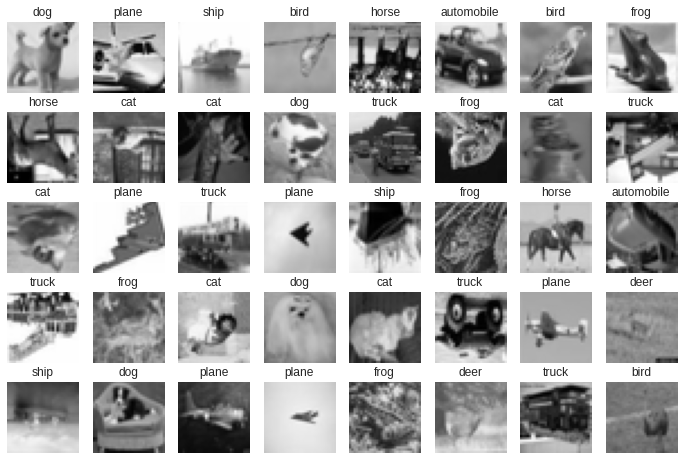

In [20]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()